In [11]:
import pandas as pd

df = pd.read_csv('./data/november_raw_data.csv')

print(df.tail())


       Departure Airport       Departure Time Arrival Airport  \
287141               DLI  2024-11-30T22:50:00             HAN   
287142               HAN  2024-12-01T07:15:00             BMV   
287143               DLI  2024-11-30T20:15:00             HAN   
287144               HAN  2024-12-01T15:35:00             BMV   
287145               DLI  2024-11-30T12:50:00             SGN   

               Arrival Time Carrier Code  Flight Number  Price (VND) Duration  
287141  2024-12-01T00:40:00           W2           4402    3950000.0  PT1H50M  
287142  2024-12-01T09:00:00           W2           4491    3950000.0  PT1H45M  
287143  2024-11-30T22:05:00           W2           4412    3950000.0  PT1H50M  
287144  2024-12-01T17:20:00           W2           4495    3950000.0  PT1H45M  
287145  2024-11-30T14:00:00           VN           1383    4115000.0  PT1H10M  


In [12]:
df['Routine'] = df['Departure Airport'] + '-' + df['Arrival Airport']

df['Departure Time'] = pd.to_datetime(df['Departure Time'])

df['Departure Month'] = df['Departure Time'].dt.month

df['Departure Day'] = df['Departure Time'].dt.day

df['Departure Hour'] = df['Departure Time'].dt.hour + df['Departure Time'].dt.minute / 60

df['Arrival Time'] = pd.to_datetime(df['Arrival Time'])

df['Arrival Month'] = df['Arrival Time'].dt.month

df['Arrival Day'] = df['Arrival Time'].dt.day

df['Arrival Hour'] = df['Arrival Time'].dt.hour + df['Arrival Time'].dt.minute / 60

df.drop(columns=['Departure Time', 'Departure Airport', 'Arrival Airport', 'Arrival Time'], inplace=True)

df.head()

,Carrier Code,Flight Number,Price (VND),Duration,Routine,Departure Month,Departure Day,Departure Hour,Arrival Month,Arrival Day,Arrival Hour
0,VJ,194,1546000.0,PT2H10M,SGN-HAN,11,1,5.000000,11,1,7.166667
1,VJ,198,1546000.0,PT2H10M,SGN-HAN,11,1,5.333333,11,1,7.500000
2,VJ,120,1546000.0,PT2H10M,SGN-HAN,11,1,6.000000,11,1,8.166667
3,VJ,122,1546000.0,PT2H10M,SGN-HAN,11,1,6.500000,11,1,8.666667
4,VJ,126,1546000.0,PT2H10M,SGN-HAN,11,1,7.500000,11,1,9.666667


In [13]:
df_encoded = df.copy()

carrier_mapping = {carrier: index for index, carrier in enumerate(df['Carrier Code'].unique())}
df_encoded['Carrier Code'] = df['Carrier Code'].map(carrier_mapping)

routine_mapping = {routine: index for index, routine in enumerate(df['Routine'].unique())}
df_encoded['Routine'] = df['Routine'].map(routine_mapping)

df_encoded['Duration'] = df['Duration'].str.findall(r'\d+').str.join('')
df_encoded['Duration'] = pd.to_numeric(df_encoded['Duration'])

print("Các cột sau khi ánh xạ:")
print(df_encoded[['Carrier Code', 'Routine', 'Duration']].head())


Các cột sau khi ánh xạ:
   Carrier Code  Routine  Duration
0             0        0       210
1             0        0       210
2             0        0       210
3             0        0       210
4             0        0       210


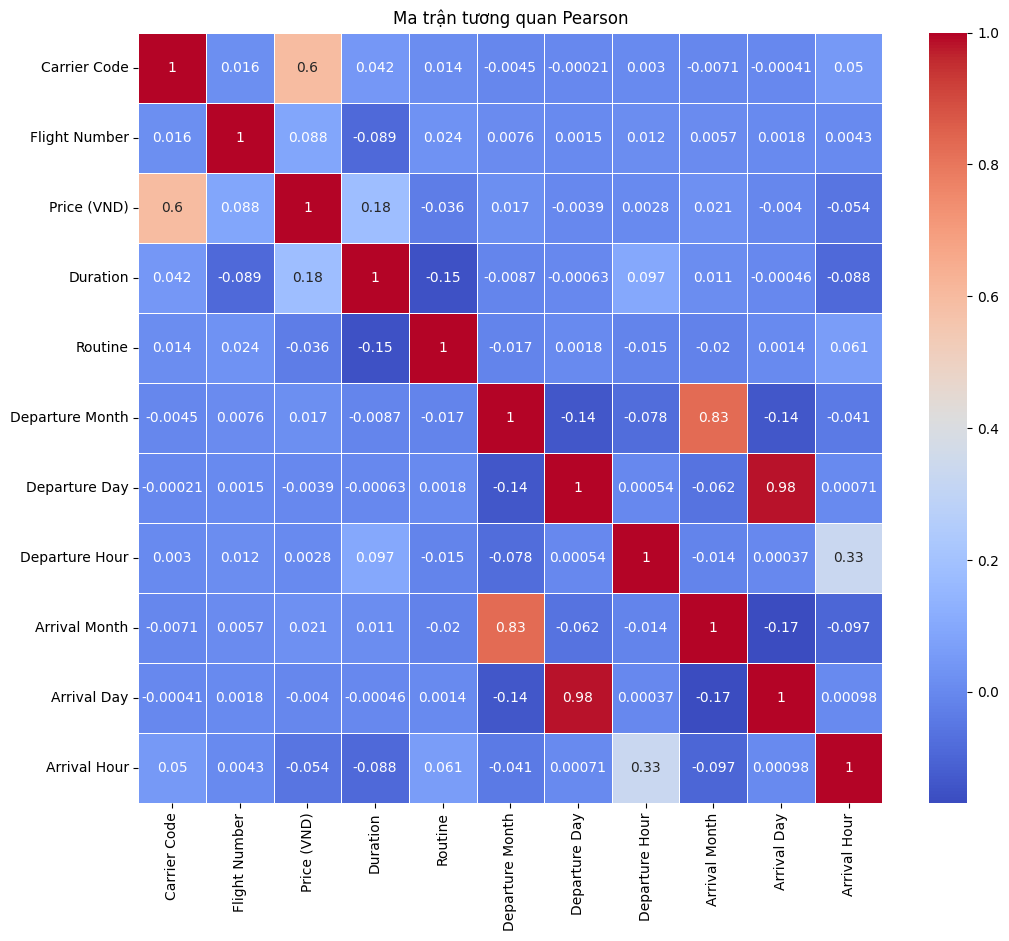

Các cặp tương quan cao nhất:
Arrival Day      Departure Day      0.981747
Departure Day    Arrival Day        0.981747
Departure Month  Arrival Month      0.826755
Arrival Month    Departure Month    0.826755
Price (VND)      Carrier Code       0.595702
Carrier Code     Price (VND)        0.595702
dtype: float64


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan Pearson')
plt.show()

print("Các cặp tương quan cao nhất:")
corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
print(sorted_pairs[(sorted_pairs < 1.0) & (sorted_pairs > 0.5)])


In [15]:
from scipy import stats

def one_way_anova(df, dependent_var, independent_var):
    groups = [group for _, group in df.groupby(independent_var)[dependent_var]]
    f_value, p_value = stats.f_oneway(*groups)
    return f_value, p_value

independent_vars = ['Carrier Code', 'Flight Number', 'Duration', 'Routine', 'Departure Month', 
                    'Departure Day', 'Departure Hour', 'Arrival Month', 'Arrival Day', 'Arrival Hour']

anova_results = []
for var in independent_vars:
    f_value, p_value = one_way_anova(df_encoded, 'Price (VND)', var)
    anova_results.append({'Biến': var, 'F-value': f_value, 'p-value': p_value})

anova_df = pd.DataFrame(anova_results)

anova_df = anova_df.sort_values('p-value')

print("Kết quả One-way ANOVA giữa Price và các biến khác:")
print(anova_df.to_string(index=False))


Kết quả One-way ANOVA giữa Price và các biến khác:
           Biến      F-value      p-value
   Carrier Code 34540.979173 0.000000e+00
  Flight Number   226.282785 0.000000e+00
       Duration  2014.204570 0.000000e+00
        Routine   301.101580 0.000000e+00
 Departure Hour   205.936690 0.000000e+00
   Arrival Hour   218.167827 0.000000e+00
  Arrival Month   121.766089 2.631521e-28
Departure Month    81.702152 1.591657e-19
  Departure Day     2.772270 1.016210e-06
    Arrival Day     2.652298 3.251100e-06
